In [1]:
import scanpy as sc
import numpy as np
import torch
import pandas as pd
from model import ZINBVAE
from dataset import base_genes
from training import train
from utils import sample_zinb, plot_column_densities, set_seed, plot_umap_pca

In [2]:
n_cells=10000
n_genes=20
target_zero_prob=.8

In [3]:
x, mu_values, theta_values, pi_values = base_genes(n_cells=n_cells, 
                                                    n_genes=n_genes, 
                                                    target_zero_prob=target_zero_prob, 
                                                    mu_bot=1.0, 
                                                    mu_top=10, 
                                                    theta_bot=0.5, 
                                                    theta_top=2.0,
                                                    seed=42)

Actual overall zero proportion: 0.7997


In [4]:
tile_up = lambda x : np.vstack((x, x))

mu_values_combined, theta_values_combined, pi_values_combined = [tile_up(mat) for mat in [mu_values, theta_values, pi_values]]

In [5]:
x_perturbed = x.copy()
x_perturbed +=10

# Stack original and perturbed data
x_combined = np.vstack((x, x_perturbed))

# Create AnnData object
adata = sc.AnnData(x_combined)

# Create state labels: first n_cells are control, next n_cells are perturbed
states = ["control"] * n_cells + ["perturbed"] * n_cells
adata.obs["state"] = pd.Categorical(states)

/mnt/data2/home/leonardo/miniconda3/envs/scvi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


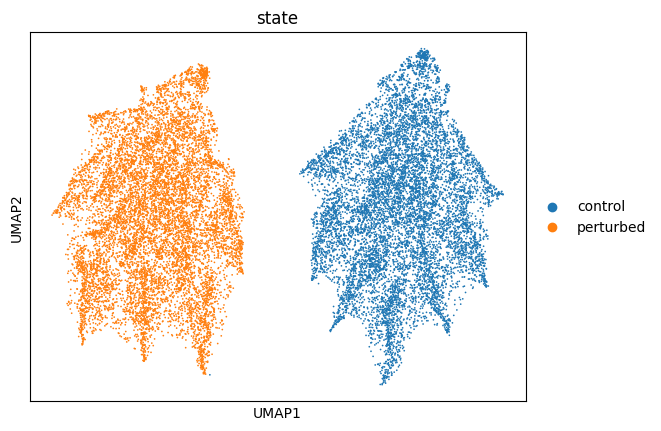

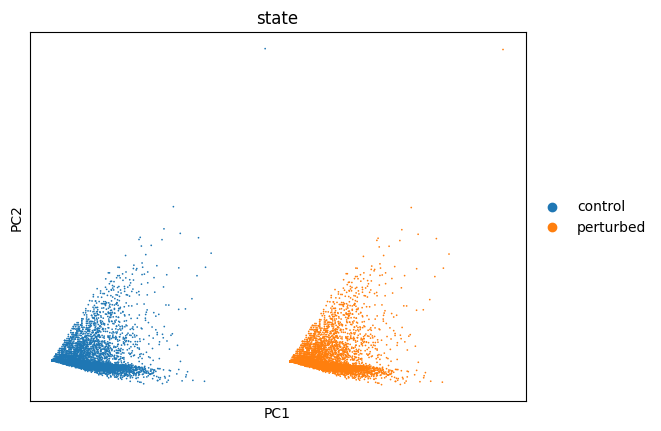

In [6]:
plot_umap_pca(adata, color="state", random_state=0)

In [7]:
n_epochs = 1000
set_seed(10)
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = ZINBVAE(input_dim=x.shape[1], hidden_dim=40, latent_dim=10)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

mean, disp, pi, mu, logvar, z = train(vae, optimizer, x_combined, n_epochs, n_cells, mu_values_combined, 
                                      theta_values_combined, pi_values_combined, seed=11, device=device)


to_numpy = lambda x: x.detach().cpu().numpy() if hasattr(x, 'detach') else np.array(x)
mean, disp, pi, mu, logvar, z = list(map(to_numpy, [mean, disp, pi, mu, logvar, z]))

Epoch 0, Loss: 41.2703, Mean MSE: 35.2440, Theta MSE: 4.1621, Pi MSE: 0.0801
Epoch 1, Loss: 38.5928, Mean MSE: 31.5646, Theta MSE: 1.7212, Pi MSE: 0.0820
Epoch 2, Loss: 35.7429, Mean MSE: 31.1572, Theta MSE: 1.2744, Pi MSE: 0.0831
Epoch 3, Loss: 32.5804, Mean MSE: 31.3902, Theta MSE: 1.4258, Pi MSE: 0.0839
Epoch 4, Loss: 29.4283, Mean MSE: 31.0160, Theta MSE: 1.2386, Pi MSE: 0.0851
Epoch 5, Loss: 26.6751, Mean MSE: 31.0176, Theta MSE: 1.2823, Pi MSE: 0.0867
Epoch 6, Loss: 24.2484, Mean MSE: 30.8193, Theta MSE: 1.2414, Pi MSE: 0.0882
Epoch 7, Loss: 22.3868, Mean MSE: 30.6632, Theta MSE: 1.2391, Pi MSE: 0.0907
Epoch 8, Loss: 20.8205, Mean MSE: 30.5883, Theta MSE: 1.2851, Pi MSE: 0.0931
Epoch 9, Loss: 19.7004, Mean MSE: 30.4335, Theta MSE: 1.2750, Pi MSE: 0.0960
Epoch 10, Loss: 18.5690, Mean MSE: 30.2344, Theta MSE: 1.2554, Pi MSE: 0.0986
Epoch 11, Loss: 17.6223, Mean MSE: 30.0965, Theta MSE: 1.2689, Pi MSE: 0.1013
Epoch 12, Loss: 16.8460, Mean MSE: 29.9472, Theta MSE: 1.2729, Pi MSE: 0.1

In [8]:
z_control_cells = z[:n_cells]
z_perturbed_cells = z[n_cells:]

mean_latent_perturbation = (z_perturbed_cells - z_control_cells).mean(axis=0)

extrapolated_z = z_control_cells + mean_latent_perturbation

extrapolated_z = torch.tensor(extrapolated_z, dtype=torch.float32).to(device)

vae.eval()
with torch.no_grad():
    mean_extr, disp_extr, pi_extr = vae.decoder(extrapolated_z)

mean_extr, disp_extr, pi_extr = [to_numpy(mat) for mat in [mean_extr, disp_extr, pi_extr]]

In [10]:
sample_extr = sample_zinb(mean=mean_extr, disp=disp_extr, pi=pi_extr, seed=11)

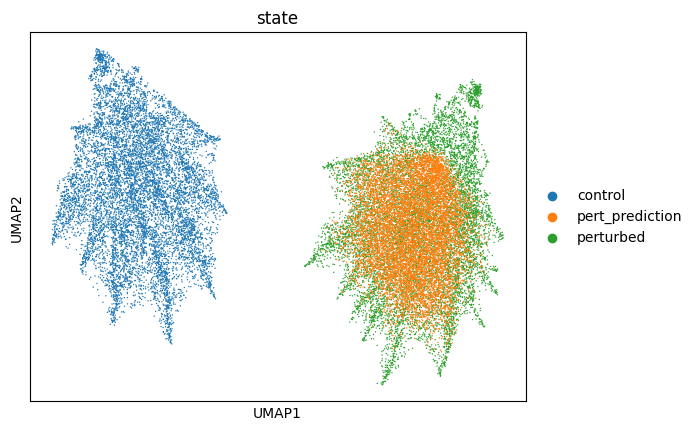

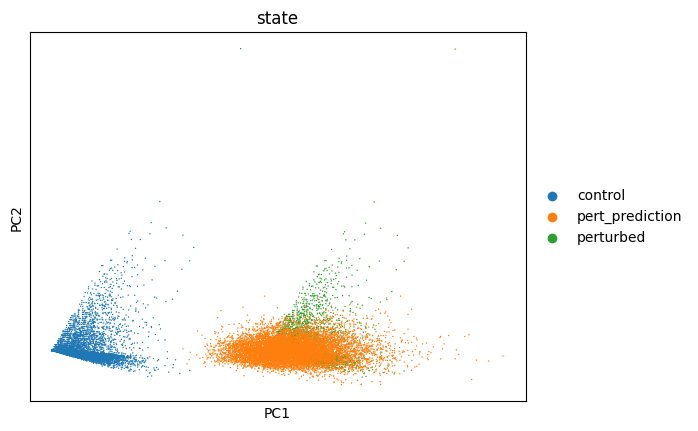

In [14]:
x_combined_final = x_combined.copy()
x_combined_final = np.vstack((x_combined_final, sample_extr))
adata = sc.AnnData(x_combined_final)
states = ["control"] * n_cells + ["perturbed"] * n_cells + ["pert_prediction"] * n_cells
adata.obs["state"] = pd.Categorical(states)
plot_umap_pca(adata, color="state", random_state=0)

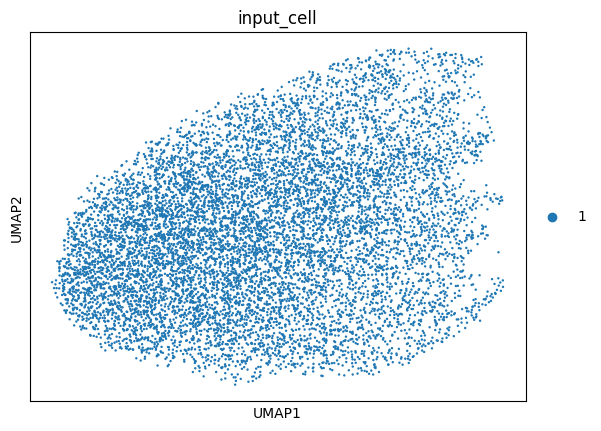

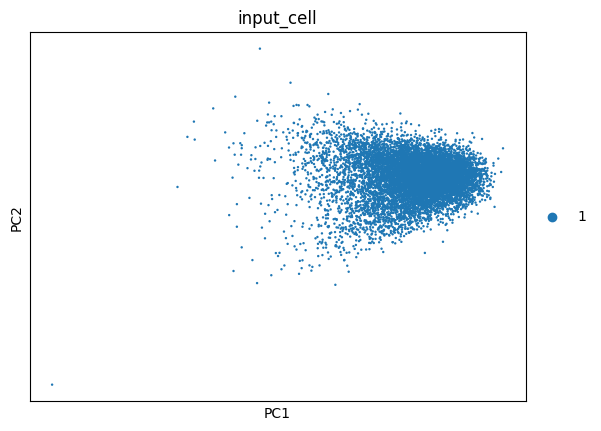

In [7]:
adata_z = sc.AnnData(X=z)
adata_z.obs["input_cell"] = adata.obs["input_cell"].copy()

plot_umap_pca(adata_z, color="input_cell", random_state=0)

In [8]:
zinb_sample = sample_zinb(mean, disp, pi, eps=1e-8, seed=11)

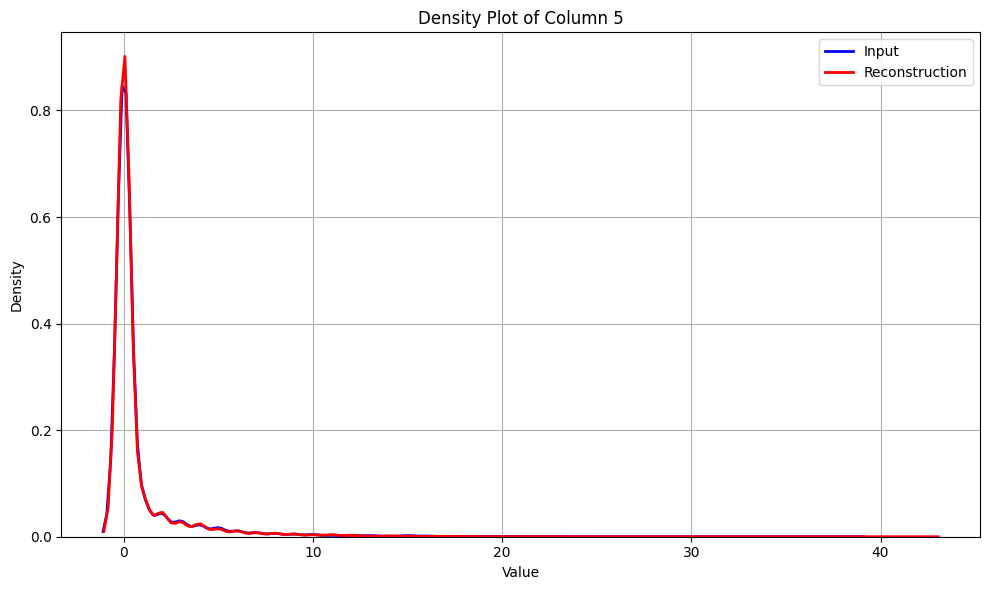

In [9]:
plot_column_densities(matrix1=x, matrix2=zinb_sample, column_index=5, label1='Input', label2='Reconstruction')

In [10]:
# Step 1: Create AnnData for the new observations
new_adata = sc.AnnData(X=zinb_sample)
new_adata.var_names = adata.var_names  # Ensure variable names match
new_adata.obs_names = [f"new_obs_{i}" for i in range(new_adata.n_obs)]

# Step 2: Assign "1" to base_gene for new observations
new_adata.obs["input_cell"] = pd.Categorical(["0"] * new_adata.n_obs)

# Step 4: Concatenate and overwrite
adata = sc.concat([adata, new_adata], axis=0)

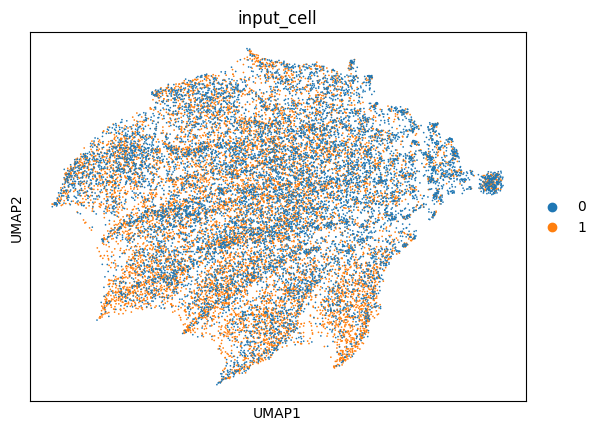

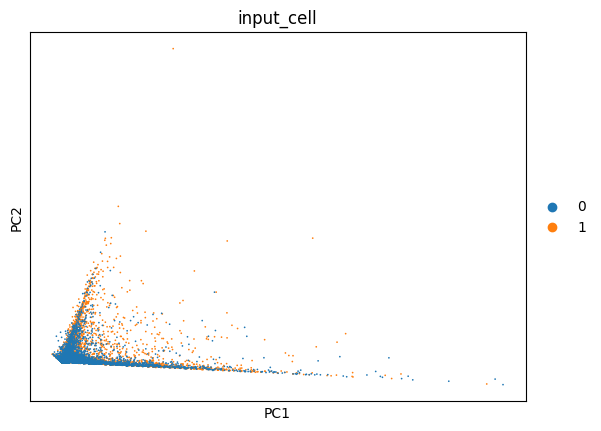

In [11]:
plot_umap_pca(adata, color="input_cell", random_state=0)